# Logistic regression with custom loss function

In this notebook, I share my solution for the August 2022 Tabular Playground Series. First, create the groups for cross-validation where three product codes are used for the training sets and two product codes are used for the validation sets resulting in a 10-fold cross-validation scheme. Next, impute loading based on the point of probability density function overlap. Since loading is the most important variable, it is imperative to calibrate it properly. Then impute measurements 3 through 9 and 17 using correlations. Finally, create a function to impute the remaining missing values and scale, cross-validate, and submit predictions.

Due to how noisy this dataset is, the most important factor for a "decent" area under the ROC curve, aside from including loading as a feature, was choosing a linear model. For this reason, and based on cross-validation results, I chose logistic regression. The loss function typically used for logistic regression is log loss. Minimizing log loss works well for increasing metrics such as accuracy, but it does not guarentee a better area under the ROC curve. Therefore, I coded my own loss function based on Mann-Whitney U test, a statistic which can be used to directly compute area under the ROC curve.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import itertools
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from cycler import cycler
from IPython.display import display
import math
import os
import random
import gc
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

import scipy.stats
from scipy.stats import rankdata

from sklearn.decomposition import PCA
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    
    tf.config.threading.set_inter_op_parallelism_threads(seed)
    tf.config.threading.set_intra_op_parallelism_threads(seed)

SEED = 1
set_global_determinism(seed=SEED)

In [3]:
train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
target = train.pop('failure')

test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')

In [4]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(train)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26568,26568,E,106.38,material_7,material_6,6,9,2,9,4,18.059,NaN,16.918,18.101,11.713,19.358,11.392,17.064,17.814,14.928,16.273,15.485,13.624,12.865,730.156
26569,26569,E,131.20,material_7,material_6,6,9,6,19,1,18.034,11.431,16.918,17.129,12.713,18.731,10.611,15.603,19.703,11.006,15.875,13.366,16.527,17.890,602.354


# Create groups for cross-validation

I use two product codes for each validation set and the remaining three for each training set:

| Fold | Training set     | Validation set |
| ----------- | ----------- | ----------- |
| 1      |   C, D, E    |    A, B    |
| 2      |  B, D, E  |   A, C    |
| 3      |   B, C, E    |    A, D    |
| 4      |  B, C, D  |   A, E    |
| 5      |   A, D, E    |    B, C    |
| 6      |  A, C, E  |   B, D    |
| 7      |   A, C, D    |    B, E    |
| 8      |  A, B, E  |   C, D    |
| 9      |   A, B, D    |    C, E    |
| 10      |  A, B, C  |   D, E    |

The rationality behind this is that it closely mimics how the model will be scored (i.e., training on one set of product codes and producing predictions on a completely different set of product codes). Since area under the ROC curve is calculated using ranking, using two product codes rather than one per validation set ensures the model is able to produce predictions for multiple codes that rank well. It is possible for a model to produce predictions for one code that are centered at one location between 0 and 1 which is different from another code which is located in another location. This would result in a poor area under the ROC curve for two product code calculation, but may be fine when calculating them individually. Therefore, a one product code per validation set could produce poor results.

In [5]:
product_code = train['product_code'].unique()
cv_groups = list(itertools.combinations(product_code,2))

training_indices = list()
validation_indices = list()

for group in cv_groups:
    temp = list()
    temp += list(train.loc[train['product_code']==group[0], :].index) + list(train.loc[train['product_code']==group[1], :].index)
    training_indices.append(list(set(list(train.index)) - set(temp)))
    validation_indices.append(temp)

# Loading imputation using Gaussian probability density functions

Loading is the most important feature. With only loading as a feature and without hyperparameter tuning, a logistic regression model will produce predictions with an area under the ROC curve of 0.58 (97% of my best CV score). Therefore, it is desirable to impute loading such that the model uses the other features to predict probabilities when loading is missing. This is done by imputing loading with the value where the probability density functions overlap for loading where failure is 1 and for loading where failure is 0.

To do this, loading must be transformed into a feature with a known probability density function. In this case, the log of loading produces samples which came from a normal distribution. This is proven by normality hypothesis testing with a null hypothesis that the log-loading came from a normal distribution:

In [6]:
print("Normality test p-values for loading distributions")
for loading in [('loading for both targets',np.log(train['loading'])), ('loading where target=0',np.log(train.loc[target==0,'loading'])), ('loading where target=1',np.log(train.loc[target==1,'loading']))]:
    print(f"{loading[0]}: {round(scipy.stats.normaltest(loading[1], nan_policy='omit')[1],2)}")

Normality test p-values for loading distributions
loading for both targets: 0.68
loading where target=0: 0.73
loading where target=1: 0.98


All p-values are larger than the significance level (0.05). Therefore, fail to reject the null hypotheses that each log-loading subsamples come from a normal distribution.

Below is a visualization of the log-transformed loading and subsamples by failure value.

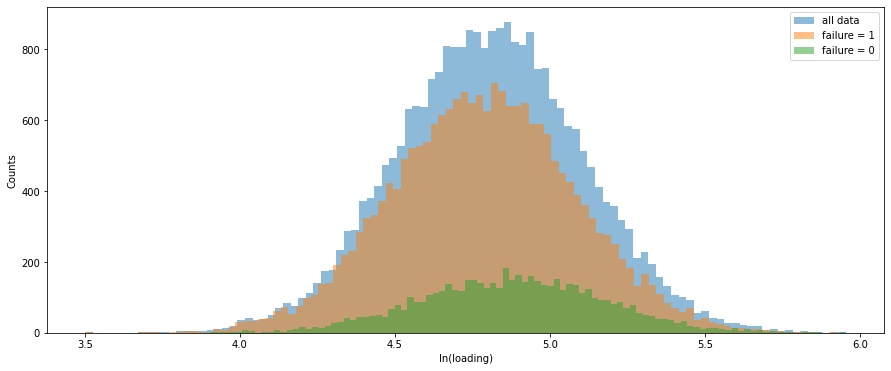

In [7]:
fig=plt.figure(figsize=(15,6))
plt.hist(np.log(train['loading']), bins=100,alpha=.5, label='all data')
plt.hist(np.log(train.loc[target==0,'loading']), bins=100,alpha=.5, label='failure = 1')
plt.hist(np.log(train.loc[target==1,'loading']), bins=100,alpha=.5, label='failure = 0')
plt.xlabel('ln(loading)')
plt.ylabel('Counts')
plt.legend()
plt.show()

Since the log-transformed subsamples of loading follow a normal distribution:

## $$(\ln(\mbox{loading})|\mbox{failure}=i)\sim \mathcal{N}(\mu_i,\sigma_i^2),\quad i=0,1$$

Set the two Gaussian probability density functions equal to each other with a log-transformed loading value $x$ and solve for $x$:

## $$\frac{1}{\sigma_0\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{\ln(x)-\mu_0}{\sigma_0}\right)^2}=\frac{1}{\sigma_1\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{\ln(x)-\mu_1}{\sigma_1}\right)^2}$$

which is equivalent to a quadratic equation in $\ln(x)$:

## $$\ln\left(\frac{\sigma_1}{\sigma_0}\right)=-\frac{1}{2}\left(\frac{\ln(x)-\mu_1}{\sigma_1}\right)^2+\frac{1}{2}\left(\frac{\ln(x)-\mu_0}{\sigma_0}\right)^2$$

In [8]:
x = train.loading.apply(np.log)
mu0, sigma0 = np.nanmean(x[target==0]), np.nanstd(x[target==0])
mu1, sigma1 = np.nanmean(x[target==1]), np.nanstd(x[target==1])
a = -1/2/sigma1**2+1/2/sigma0**2
b = -mu0/sigma0**2+mu1/sigma1**2
c = mu0**2/2/sigma0**2-mu1**2/2/sigma1**2-np.log(sigma1/sigma0)
D = b**2-4*a*c
loading_imputation_value = np.exp((-b+np.sqrt(D))/2/a)
print(f"Loading value of intersection between probability density functions for failure==0 and failure==1: {np.round(np.exp((-b+np.sqrt(D))/2/a),2)}")

Loading value of intersection between probability density functions for failure==0 and failure==1: 127.23


In [9]:
# Impute loading with constant value 127.23.
train['loading'].fillna(value=loading_imputation_value, inplace=True)
test['loading'].fillna(value=loading_imputation_value, inplace=True)

# Impute measurements 3 through 9 and 17 using correlations

A new feature can be created by summing the product of measurements 3 through 9 and correlation with measurement 17 (when the correlation is positively correlated and greater than 0.1) for each product code. This new feature is almost perfectly correlated with measurement 17. The expression for the new feature is given by

## $$ Y =  \sum_{i=3}^{9}  C_{i}X_{i} I(C_{i} \ge 0.1)$$

Measurement 17 and the new correlation feature can be expressed as a linear equation:

## $$ X_{17} = m(Y) + b$$

where $b$ and $m$ need to be calculated for each product code.

You can find, for example, missing measurement 3 if that is the only missing value in the row using the following

## $$ X_{3} = -\dfrac{[\sum_{i=4}^{9}  C_{i}X_{i}I(C_{i} \ge 0.1)] - \dfrac{X_{17} - b}{m}}{C_{3}}$$

Below are the correlations between measurements 3 through 9 and 17 by product code.

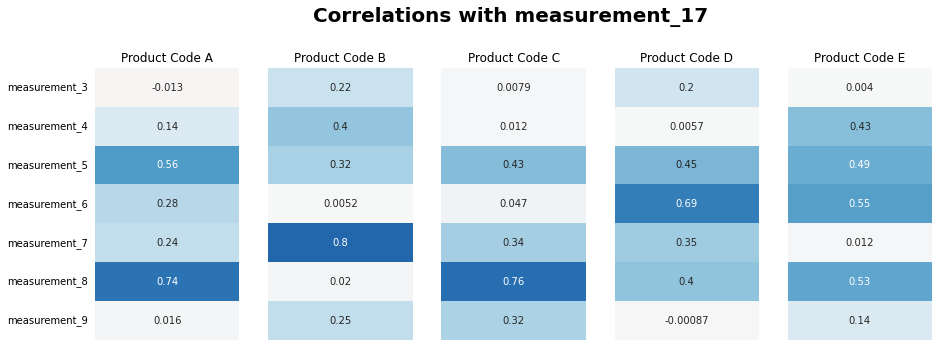

In [10]:
fig = plt.figure(figsize=(15,5))
x=1
for product_code in train['product_code'].unique():
    ax = fig.add_subplot(1,5,x)
    corr_columns = list(train.columns[7:])
    corr = train.loc[train['product_code']==product_code,corr_columns].corr()
    if x == 1:
        g = sn.heatmap(pd.DataFrame(corr.iloc[-1,3:-8]), cmap ="RdBu", annot=True, vmin=-1, vmax=1, ax=ax, cbar=False)
        g.set(xticklabels=[])
        g.tick_params(left=False, bottom=False)
    else:
        g = sn.heatmap(pd.DataFrame(corr.iloc[-1,3:-8]), cmap ="RdBu", annot=True, vmin=-1, vmax=1, ax=ax, cbar=False)
        g.set(yticklabels=[], xticklabels=[])
        g.tick_params(left=False, bottom=False)
    plt.title(f"Product Code {product_code}")
    x+=1

ttl = fig.suptitle('Correlations with measurement_17', fontsize=20, fontweight="bold")
ttl.set_position([.51, 1.05])
plt.show()

Below is the imputation of measurements 3 through 9 and 17 for the training dataframe.

In [11]:
corr_features = list(train.columns[10:17])
product_codes = list(train['product_code'].unique())

correlations_by_code = list()
for code in product_codes:
    corr = list(train.loc[train['product_code']==code, corr_features+['measurement_17']].corr().iloc[-1,:].values[:-1])
    correlations_by_code.append(corr)
    
print("Number of missing values by row prior to imputation:")
print(train.loc[:,corr_features + ['measurement_17']].isna().sum(axis=1).value_counts())
print("\n")

originally_null = train.isna().sum().sum()

for idx,correlation_group in enumerate(correlations_by_code):
    
    new_number_null = -9999
    current_number_null = train.isna().sum().sum()
    
    while new_number_null != current_number_null:
        
        current_number_null = train.isna().sum().sum()
        
        #m_17
        lr = LinearRegression()
        temp = pd.Series(np.zeros(train[train['product_code']==product_codes[idx]].shape[0]))
        reverse_impute = list()
        for idx_2,correlation in enumerate(correlation_group):
            if correlation >= 0.10:
                reverse_impute.append(corr_features[idx_2])
                temp += (correlation*(train.loc[train['product_code'] == product_codes[idx], corr_features[idx_2]])).reset_index(drop=True)
        
        m_17 = train.loc[train['product_code']==product_codes[idx], 'measurement_17'].reset_index(drop=True).copy()        
        
        not_null = (m_17.notnull() & temp.notnull())
        lr.fit(temp[not_null].values.reshape(-1,1), m_17[not_null].values.reshape(-1,1))

        m = lr.coef_ 
        b = lr.intercept_
        
        m_17_null_only = (m_17.isnull() & temp.notnull())
        if m_17_null_only.sum() > 0:
            m_17.loc[m_17_null_only] = lr.predict(temp[m_17_null_only].values.reshape(-1,1)).squeeze()
            indices = train.loc[train['product_code']==product_codes[idx],'measurement_17'].index
            train.loc[train['product_code']==product_codes[idx],'measurement_17'] = np.array(m_17)
        
        #m_3 to m_9
        for idx_feature, feature in enumerate(corr_features):
            cannot_impute = False
            temp = pd.Series(np.zeros(train[train['product_code']==product_codes[idx]].shape[0]))
            
            if feature in reverse_impute:
                for idx_2,correlation in enumerate(correlation_group):
                    if idx_2 == idx_feature:
                        pass
                    else:
                        if correlation >= 0.10:
                            temp += (correlation*(train.loc[train['product_code'] == product_codes[idx], corr_features[idx_2]])).reset_index(drop=True) 
                        
            
                current_measurement = train.loc[train['product_code']==product_codes[idx], feature].reset_index(drop=True).copy()

                temp -= (train.loc[train['product_code']==product_codes[idx], 'measurement_17'].reset_index(drop=True).copy() - b[0])/m[0][0] #off by a factor
                temp /= -correlation_group[idx_feature]

                not_null = (current_measurement.notnull() & temp.notnull())
                lr.fit(temp[not_null].values.reshape(-1,1), current_measurement[not_null].values.reshape(-1,1))
                current_measurement_null_only = (current_measurement.isnull() & temp.notnull())

                if current_measurement_null_only.sum() > 0:
                    current_measurement.loc[current_measurement_null_only] = lr.predict(temp[current_measurement_null_only].values.reshape(-1,1)).squeeze()
                    train.loc[train['product_code']==product_codes[idx],feature] = np.array(current_measurement)
            
        new_number_null = train.isna().sum().sum()
        
print(f"Missing values filled: {originally_null - current_number_null}\n\n")

print("Number of missing values by row after imputation:")
print(train.loc[:,corr_features + ['measurement_17']].isna().sum(axis=1).value_counts())

Number of missing values by row prior to imputation:
0    19632
1     6056
2      817
3       63
4        2
dtype: int64


Missing values filled: 5137


Number of missing values by row after imputation:
0    24450
1     1556
2      500
3       62
4        2
dtype: int64


Below is the imputation of measurements 3 through 9 and 17 for the test dataframe.

In [12]:
corr_features = list(test.columns[10:17])
product_codes = list(test['product_code'].unique())

correlations_by_code = list()
for code in product_codes:
    corr = list(test.loc[test['product_code']==code, corr_features+['measurement_17']].corr().iloc[-1,:].values[:-1])
    correlations_by_code.append(corr)
    
print("Number of missing values by row prior to imputation:")
print(test.loc[:,corr_features + ['measurement_17']].isna().sum(axis=1).value_counts())
print("\n")

originally_null = test.isna().sum().sum()

for idx,correlation_group in enumerate(correlations_by_code):
    
    new_number_null = -9999
    current_number_null = test.isna().sum().sum()
    
    while new_number_null != current_number_null:
        
        current_number_null = test.isna().sum().sum()
        
        #m_17
        lr = LinearRegression()
        temp = pd.Series(np.zeros(test[test['product_code']==product_codes[idx]].shape[0]))
        reverse_impute = list()
        for idx_2,correlation in enumerate(correlation_group):
            if correlation >= 0.10:
                reverse_impute.append(corr_features[idx_2])
                temp += (correlation*(test.loc[test['product_code'] == product_codes[idx], corr_features[idx_2]])).reset_index(drop=True)
        
        m_17 = test.loc[test['product_code']==product_codes[idx], 'measurement_17'].reset_index(drop=True).copy()      
        
        not_null = (m_17.notnull() & temp.notnull())
        lr.fit(temp[not_null].values.reshape(-1,1), m_17[not_null].values.reshape(-1,1))

        m = lr.coef_ 
        b = lr.intercept_
        
        m_17_null_only = (m_17.isnull() & temp.notnull())
        if m_17_null_only.sum() > 0:
            m_17.loc[m_17_null_only] = lr.predict(temp[m_17_null_only].values.reshape(-1,1)).squeeze()
            indices = test.loc[test['product_code']==product_codes[idx],'measurement_17'].index
            test.loc[test['product_code']==product_codes[idx],'measurement_17'] = np.array(m_17)
        
        #m_3 to m_9
        for idx_feature, feature in enumerate(corr_features):
            cannot_impute = False
            temp = pd.Series(np.zeros(test[test['product_code']==product_codes[idx]].shape[0]))
            
            if feature in reverse_impute:
                for idx_2,correlation in enumerate(correlation_group):
                    if idx_2 == idx_feature:
                        pass
                    else:
                        if correlation >= 0.10:
                            temp += (correlation*(test.loc[test['product_code'] == product_codes[idx], corr_features[idx_2]])).reset_index(drop=True) 
                        
            
                current_measurement = test.loc[test['product_code']==product_codes[idx], feature].reset_index(drop=True).copy()

                temp -= (test.loc[test['product_code']==product_codes[idx], 'measurement_17'].reset_index(drop=True).copy() - b[0])/m[0][0] #off by a factor
                temp /= -correlation_group[idx_feature]

                not_null = (current_measurement.notnull() & temp.notnull())
                lr.fit(temp[not_null].values.reshape(-1,1), current_measurement[not_null].values.reshape(-1,1))
                current_measurement_null_only = (current_measurement.isnull() & temp.notnull())

                if current_measurement_null_only.sum() > 0:
                    current_measurement.loc[current_measurement_null_only] = lr.predict(temp[current_measurement_null_only].values.reshape(-1,1)).squeeze()
                    test.loc[test['product_code']==product_codes[idx],feature] = np.array(current_measurement)
            
        new_number_null = test.isna().sum().sum()
        
print(f"Missing values filled: {originally_null - current_number_null}\n\n")

print("Number of missing values by row after imputation:")
print(test.loc[:,corr_features + ['measurement_17']].isna().sum(axis=1).value_counts())

Number of missing values by row prior to imputation:
0    15390
1     4734
2      607
3       44
dtype: int64


Missing values filled: 3996


Number of missing values by row after imputation:
0    19143
1     1220
2      372
3       40
dtype: int64


# Cross-validation pre-processing functions

The following functions are for use during cross-validation to impute and scale the training and validation sets.

This first function imputes the remaining missing values based on correlation between the variables using KNNImputer and HuberRegressor.

In [13]:
def impute(df):
        
    feature = [f for f in df.columns if f.startswith('measurement') or f=='loading']

    full_fill_dict ={}
    full_fill_dict['measurement_17'] = {
        'A': [                'measurement_4','measurement_5','measurement_6','measurement_7','measurement_8'],
        'B': ['measurement_3','measurement_4','measurement_5',                'measurement_7',                'measurement_9'],
        'C': [                                'measurement_5','measurement_6','measurement_7','measurement_8','measurement_9'],
        'D': ['measurement_3',                'measurement_5','measurement_6','measurement_7','measurement_8'],
        'E': [                'measurement_4','measurement_5','measurement_6',                'measurement_8','measurement_9'],
        'F': [                'measurement_4','measurement_5','measurement_6','measurement_7'],
        'G': [                'measurement_4','measurement_5','measurement_6',                'measurement_8','measurement_9'],
        'H': [                'measurement_4','measurement_5',                'measurement_7','measurement_8','measurement_9'],
        'I': ['measurement_3','measurement_4',                'measurement_7','measurement_8','measurement_9']
    }

    col = [col for col in df.columns if 'measurement' not in col] + ['loading']
    a = []
    b =[]

    for x in range(3,17):
        corr = np.absolute(df.drop(col, axis=1).corr()[f'measurement_{x}']).sort_values(ascending=False)
        a.append(np.round(np.sum(corr[1:4]),3))
        b.append(f'measurement_{x}')

    c = pd.DataFrame()
    c['Selected columns'] = b
    c['correlation total'] = a
    c = c.sort_values(by = 'correlation total',ascending=False).reset_index(drop = True)

    for i in range(10):
        measurement_col = 'measurement_' + c.iloc[i,0][12:] # we select the next best correlated column 
        fill_dict ={}
        for x in df.product_code.unique() : 
            corr = np.absolute(df[df.product_code == x].drop(col, axis=1).corr()[measurement_col]).sort_values(ascending=False)
            measurement_col_dic = {}
            measurement_col_dic[measurement_col] = corr[1:5].index.tolist()
            fill_dict[x] = measurement_col_dic[measurement_col]
        full_fill_dict[measurement_col] =fill_dict

    feature = [f for f in df.columns if f.startswith('measurement') or f=='loading']
    nullValue_cols = [col for col in df.columns if df[col].isnull().sum()!=0]

    for code in df.product_code.unique():
        total_na_filled_by_linear_model = 0
        for measurement_col in list(full_fill_dict.keys()):
            tmp = df.loc[df.product_code==code,:].copy()
            column = full_fill_dict[measurement_col][code]
            tmp_train = tmp.loc[:, column+[measurement_col]].dropna(how='any').copy()
            tmp_test = tmp.loc[(tmp[column].isnull().sum(axis=1)==0)&(tmp[measurement_col].isnull()),:].copy()

            model = HuberRegressor(epsilon=1.9, max_iter=500)
            model.fit(tmp_train.loc[:,column].copy(), tmp_train.loc[:,measurement_col].copy())
            try:
                df.loc[(df.product_code==code)&(df[column].isnull().sum(axis=1)==0)&(df[measurement_col].isnull()), measurement_col] = model.predict(tmp_test.loc[:,column])
            except:
                pass

        NA = df.loc[df["product_code"] == code,nullValue_cols].isnull().sum().sum()
        model1 = KNNImputer(n_neighbors=3)
        df.loc[df.product_code==code, feature] = model1.fit_transform(df.loc[df.product_code==code, feature])

    df['measurement_avg'] = df[[f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)
        
    return df

This second function scales the features. For all features except attribute_3, remove the median and scale data according to quantile ranges found through cross-validation by product_code. attribute_3 was standardized, because there were only five unique values where each product_code has only one value.

Below are plots showing the quantile ranges for the loading and measurement features by product code.

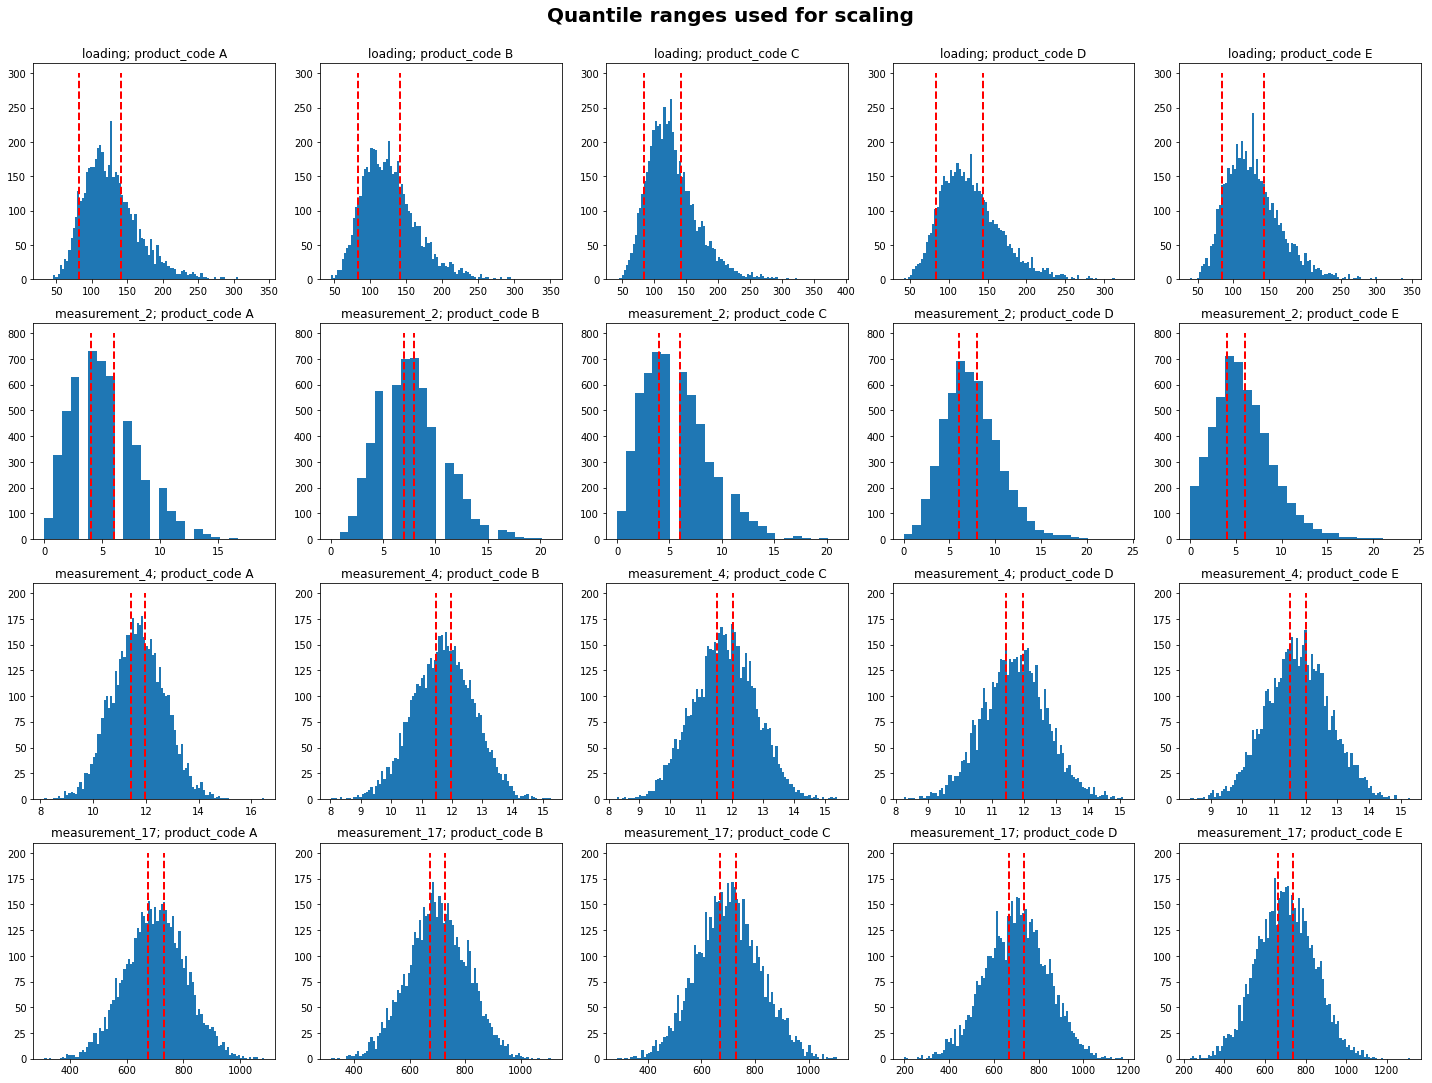

In [14]:
fig = plt.figure(figsize=(20,15))
x=1
for i in train['product_code'].unique():
    ax = fig.add_subplot(4,5,x)
    plt.hist(train.loc[train['product_code']==i,'loading'], bins=100)
    plt.vlines(x=train.loc[train['product_code']==i,'loading'].quantile(.10), ymin=0, ymax=300, linewidth=2, color='r', linestyles='dashed')
    plt.vlines(x=train.loc[train['product_code']==i,'loading'].quantile(.70), ymin=0, ymax=300, linewidth=2, color='r', linestyles='dashed')
    plt.title(f'loading; product_code {i}')
    x+=1
for i in train['product_code'].unique():
    ax = fig.add_subplot(4,5,x)
    plt.hist(train.loc[train['product_code']==i,'measurement_2'], bins=train['measurement_2'].nunique())
    plt.vlines(x=train.loc[train['product_code']==i,'measurement_2'].quantile(.40), ymin=0, ymax=800, linewidth=2, color='r', linestyle='dashed')
    plt.vlines(x=train.loc[train['product_code']==i,'measurement_2'].quantile(.60), ymin=0, ymax=800, linewidth=2, color='r', linestyle='dashed')
    plt.title(f'measurement_2; product_code {i}')
    x+=1
for i in train['product_code'].unique():
    ax = fig.add_subplot(4,5,x)
    plt.hist(train.loc[train['product_code']==i,'measurement_4'], bins=100)
    plt.vlines(x=train.loc[train['product_code']==i,'measurement_4'].quantile(.40), ymin=0, ymax=200, linewidth=2, color='r', linestyles='dashed')
    plt.vlines(x=train.loc[train['product_code']==i,'measurement_4'].quantile(.60), ymin=0, ymax=200, linewidth=2, color='r', linestyles='dashed')
    plt.title(f'measurement_4; product_code {i}')
    x+=1
for i in train['product_code'].unique():
    ax = fig.add_subplot(4,5,x)
    plt.hist(train.loc[train['product_code']==i,'measurement_17'], bins=100)
    plt.vlines(x=train.loc[train['product_code']==i,'measurement_17'].quantile(.40), ymin=0, ymax=200, linewidth=2, color='r', linestyles='dashed')
    plt.vlines(x=train.loc[train['product_code']==i,'measurement_17'].quantile(.60), ymin=0, ymax=200, linewidth=2, color='r', linestyles='dashed')
    plt.title(f'measurement_17; product_code {i}')
    x+=1
ttl = fig.suptitle('Quantile ranges used for scaling', fontsize=20, fontweight="bold")
ttl.set_position([.51, 1.00])
plt.tight_layout()
plt.show()

In [15]:
def scale(X_train, X_valid):

    measurements = ['measurement_2', 'measurement_4', 'measurement_17']
    
    loading_scaler = RobustScaler(quantile_range=(10,70))
    measurement_scaler = RobustScaler(quantile_range=(40,60))

    for train_code in X_train['product_code'].unique():
        X_train.loc[X_train['product_code']==train_code,'loading'] = loading_scaler.fit_transform(X_train.loc[X_train['product_code']==train_code,'loading'].values.reshape(-1,1))
        X_train.loc[X_train['product_code']==train_code,measurements] = measurement_scaler.fit_transform(X_train.loc[X_train['product_code']==train_code,measurements])
        
    for valid_code in X_valid['product_code'].unique():
        X_valid.loc[X_valid['product_code']==valid_code,'loading'] = loading_scaler.fit_transform(X_valid.loc[X_valid['product_code']==valid_code,'loading'].values.reshape(-1,1))
        X_valid.loc[X_valid['product_code']==valid_code,measurements] = measurement_scaler.fit_transform(X_valid.loc[X_valid['product_code']==valid_code,measurements])
        
    attribute_scaler = StandardScaler()
    X_train['attribute_3'] = attribute_scaler.fit_transform(X_train['attribute_3'].values.reshape(-1,1))
    X_valid['attribute_3'] = attribute_scaler.transform(X_valid['attribute_3'].values.reshape(-1,1))
    
    features = ['loading', 'measurement_2','measurement_17', 'measurement_4', 'attribute_3']
    
    return X_train.loc[:,features], X_valid.loc[:,features]

This last function combines the previous functions.

In [16]:
def preprocess_data(X_train, X_valid):
        
    X_train = impute(X_train)
    X_valid = impute(X_valid)

    features = ['product_code','loading', 'measurement_2','measurement_17', 'attribute_3', 'measurement_4']
    X_train, X_valid = scale(X_train[features], X_valid[features])
    
    X_train = np.array(X_train)
    X_valid = np.array(X_valid)
    
    return X_train, X_valid

# Wilcoxon-Mann-Whitney statistic as a loss function

Minimizing log loss and binary cross-entropy do not necessarily yield a better AUC-ROC. Therefore, it may be better to use a loss function based on the normalized Wilcoxon-Mann-Whitney (WMW) statistic which is used for nonparametric hypothesis tests and for computing AUC-ROC.

The idea for an alternative loss function was found in the following paper:

[Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic. Yan, Lian and Dodier, Robert H. and Mozer, Michael and Wolniewicz, Richard H. International Conference on Machine Learning (2003).](https://www.aaai.org/Papers/ICML/2003/ICML03-110.pdf)

The WMW statistic is calculated using the following

## $$U = \frac{\sum_{i=0}^{m-1} \sum_{j=0}^{n-1} I(x_{i}, y_{j})}{mn}$$

where

## $$I(x_{i}, y_{j}) =\left\{\begin{array}{lr} 1 : x_{i} > y_{j}\\ 0 : otherwise\end{array}\right\}$$

$m$ and $n$ are the sizes of the $x$ and $y$ samples. $I$ is an indicator function which is non-differentiable. This statistic can be used to test the null hypothesis that the $P(X > Y) = P(Y > X)$. In this setting, $X$ and $Y$ are the positive and negative predictions output from the models.

$U$ is proportional to AUC-ROC, see [Wikipedia](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Area-under-curve_(AUC)_statistic_for_ROC_curves). Therefore, we would ideally like to maximize $U$ which would maximize the AUC-ROC. This would be done by flipping the inequality of the indicator creating a loss function to minimize. Unfortunately, loss functions need to be differentiable to calculate gradients.

The researchers from the paper suggest using an approximation of the indicator given by

## $$R(x_{i}, y_{j}) =\left\{\begin{array}{lr} (-(x_{i} - y_{j} - \gamma)^{p}) : x_{i} - y_{j} < \gamma\\ 0 : otherwise\end{array}\right\}$$

where $0 < \gamma \le 1$ and $p > 1$. When a positive sample has a higher output than a negative sample by a margin gamma, the pair of samples will not contribute to the loss function. Gamma is needed for better generalization performance.

Therefore, the loss function to minimize becomes

## $$U_{R}= \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} R(x_{i}, y_{j})$$

Below is the implementation of this loss function using TensorFlow.

In [17]:
def WMWStatistic(gamma=0.4, p=2):
    
    """Computes a loss function based on the approximation of the normalized
    Wilcoxon-Mann-Whitney (WMW) statistic.
    
    The normalized WMW statistic can be shown to be equivalent to the area under
    the ROC curve. However, the statistic is a step function so it is not
    differentiable. The normalized WCW statistic can be approximated with a smooth,
    differentiable function which makes the approximated version an ideal loss
    function for optimizing for the AUC-ROC metric.
    
    The loss function has two parameters, gamma and p, which are recommended
    to be kept between 0.1 to 0.7 and at 2 or 3, respectively.
    
    For more information:
    Optimizing Classifier Performance via an Approximation to the
    Wilcoxon-Mann-Whitney Statistic. Yan, Lian and Dodier, Robert H. and Mozer,
    Michael and Wolniewicz, Richard H. International Conference on Machine
    Learning (2003).
    """ 
    
    def loss(y_true, y_pred):

        # Convert labels and predictions to float64.
        y_true = tf.cast(y_true, dtype="float64")
        y_pred = tf.cast(y_pred, dtype="float64")

        # Boolean vector for determining positive and negative labels.
        boolean_vector = tf.greater_equal(y_true, 0.5)

        # Mask predictions to seperate true positive and negatives.
        positive_predictions = tf.boolean_mask(y_pred, boolean_vector)
        negative_predictions = tf.boolean_mask(y_pred, ~boolean_vector)

        # Obtain size of new arrays.
        m = tf.reduce_sum(tf.cast(boolean_vector, dtype="float64"))
        n = tf.reduce_sum(tf.cast(~boolean_vector, dtype="float64"))

        # Reshape arrays into original shape.
        positive_predictions = tf.reshape(positive_predictions, shape=(m,1))
        negative_predictions = tf.reshape(negative_predictions, shape=(n,1))

        # Convert gamma parameter to float64.
        gamma_array = tf.constant(gamma, dtype="float64")

        # Broadcast gamma parameter to MxN matrix.
        gamma_array = tf.broadcast_to(gamma_array, shape=(m,n))

        # Broadcast positive predictions to MxN.
        positive_predictions = tf.broadcast_to(positive_predictions, shape=(m,n))

        # Broadcast negative predictions to NxM then transpose.
        negative_predictions = tf.transpose(tf.broadcast_to(negative_predictions,
                                                   shape=(n,m)))  
    
        # Subtract positive predictions matrix from negative predictions matrix.
        sub_neg_pos = tf.subtract(negative_predictions, positive_predictions)

        # Add gamma matrix to subtracted negative/positive matrix.
        add_gamma = tf.add(sub_neg_pos, gamma_array)

        # Check if positive predictions are less than negative predictions plus
        # gamma.
        inequality_check = tf.math.less(tf.subtract(positive_predictions,
                                                    negative_predictions), gamma)

        # Convert Boolean values to float64.
        inequality_check = tf.cast(inequality_check, dtype="float64")

        # Element-wise multiplication which effectively masks values that do not
        # meet inequality criterion.
        inequality_mask = tf.math.multiply(inequality_check, add_gamma)

        # Element-wise raise to power P.
        raise_to_p = tf.math.pow(inequality_mask, p)

        # Sum all elements.
        return tf.reduce_sum(raise_to_p)

    return loss

# Logistic regression model using TensorFlow and Keras

It's easier to create and implement a custom loss function in TensorFlow and Keras than it is using Scikit-learn. Therefore, I create a logistic regression model using TensorFlow and Keras.

For callbacks, I used learning rate scheduler with a cosine decay and early stopping based on val_loss.

In [18]:
CYCLES = 100
EPOCHS = 40*CYCLES
EPOCHS_COSINEDECAY = 40*CYCLES
VERBOSE = 0
BATCH_SIZE = 32
epochs = EPOCHS_COSINEDECAY
lr_end = 0.00001
lr_start = 0.0001

def cosine_decay(epoch):
    epochs_per_cycle = epochs // CYCLES
    epoch_in_cycle = epoch % epochs_per_cycle
    if epochs_per_cycle > 1:
        w = (1 + math.cos(epoch_in_cycle / (epochs_per_cycle-1) * math.pi)) / 2
    else:
        w = 1
    return w * lr_start + (1 - w) * lr_end

lr = LearningRateScheduler(cosine_decay, verbose=0)
es= EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=80)
callbacks = [lr, es]

After parameter tuning, the best optimizer was determined to be Adam and loss parameters were determined to be $\gamma = 0.03$ and $p = 3$. The num_thresholds for the AUC metric was set to 2500 to increase accuracy of the Riemann sum approximation of AUC which Keras uses.

In [19]:
OPTIMIZER = tf.keras.optimizers.Adam()
LOSS = WMWStatistic(gamma=0.03, p=3)
METRIC = tf.keras.metrics.AUC(name='auc', num_thresholds=2500)

In [20]:
def lr_model():
    inputs = Input(shape=(5))
    outputs = Dense(
            1,
            activation='sigmoid',
            )(inputs)
    model = Model(inputs, outputs)
    return model

The dataset has a slight class imbalance. To mitigate this, a modified class weight is used to alter the loss function. The loss function then becomes

## $$Loss = wU_{R}$$

where

## $$w =\left\{\begin{array}{lr} \frac{m+n}{2m} : failure = 1 \\ \frac{m+n}{2n} : failure = 0\end{array}\right\}$$



In [21]:
def get_class_weight(y):
    classes = y.value_counts().index
    samples_per_class = y.value_counts().values
    n_classes = len(classes)
    n_samples = len(y)
    weights = n_samples/(n_classes*samples_per_class)
    return dict(zip(classes,weights))

# Cross-validation with two product codes per validation set

In [22]:
# Plots training history, ROC curve, and coefficients for each fold.
def plot_history(history, *, n_epochs=None, plot_lr=False, title=None, bottom=None, top=None, loss_or_metric=None, val_loss_or_metric=None, y_pred = None,
                 y_pred_proba=None, y_valid=None, X_valid_auc=None, weights=None):

    plt.figure(figsize=(30, 8))
    plt.subplot(1,3, 1)
    from_epoch = 0 if n_epochs is None else max(len(history[loss_or_metric]) - n_epochs, 0)
    
    plt.plot(np.arange(from_epoch, len(history[loss_or_metric])), history[loss_or_metric][from_epoch:], label = loss_or_metric)
    
    try:
        plt.plot(np.arange(from_epoch, len(history[loss_or_metric])), history[val_loss_or_metric][from_epoch:], label = val_loss_or_metric)
        if val_loss_or_metric == 'val_loss':
            best_epoch = np.argmin(np.array(history[val_loss_or_metric]))
        else:
            best_epoch = np.argmax(np.array(history[val_loss_or_metric]))
        best_val_loss = history[val_loss_or_metric][best_epoch]
            
    except KeyError:
        pass
    
    if bottom is not None: plt.ylim(bottom=bottom)
        
    if top is not None: plt.ylim(top=top)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel(f'{loss_or_metric}')
    plt.legend(loc ='lower left')
    
    if title is not None: plt.title(title)
        
    if plot_lr and 'lr' in history:
        ax2 = plt.gca().twinx()
        ax2.plot(np.arange(
                    from_epoch, 
                    len(history['lr'])),
                    np.array(history['lr'][from_epoch:]),
                 color='g', label ='Learning rate')
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='lower right')
    
    plt.subplot(1,3,2)
    fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
    plt.plot(fpr, tpr, "b", label='Logistic regression')
    plt.plot([0,1],[0,1], "k--", label='Random guess')
    plt.xlabel("False positive rate")
    plt.xlim((0,1))
    plt.ylabel("True positive rate")
    plt.ylim((0,1))
    plt.title(f"Validation Set ROC Curve\nAUC: {X_valid_auc}")
    
    plt.subplot(1,3,3)
    features = ['loading', 'measurement_2', 'measurement_17', 'measurement_4', 'attribute_3']
    sn.barplot(y=features, x=weights, orient='h')
    plt.title("Feature Weights")
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
    plt.show()

Below are the results from cross-validation. The left plot is the training history, middle plot is the out-of-fold ROC curve, and right plot contains the coefficients. The out-of-fold area under the ROC curve calculation is displayed above the middle plot.

2022-09-01 17:35:41.437206: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


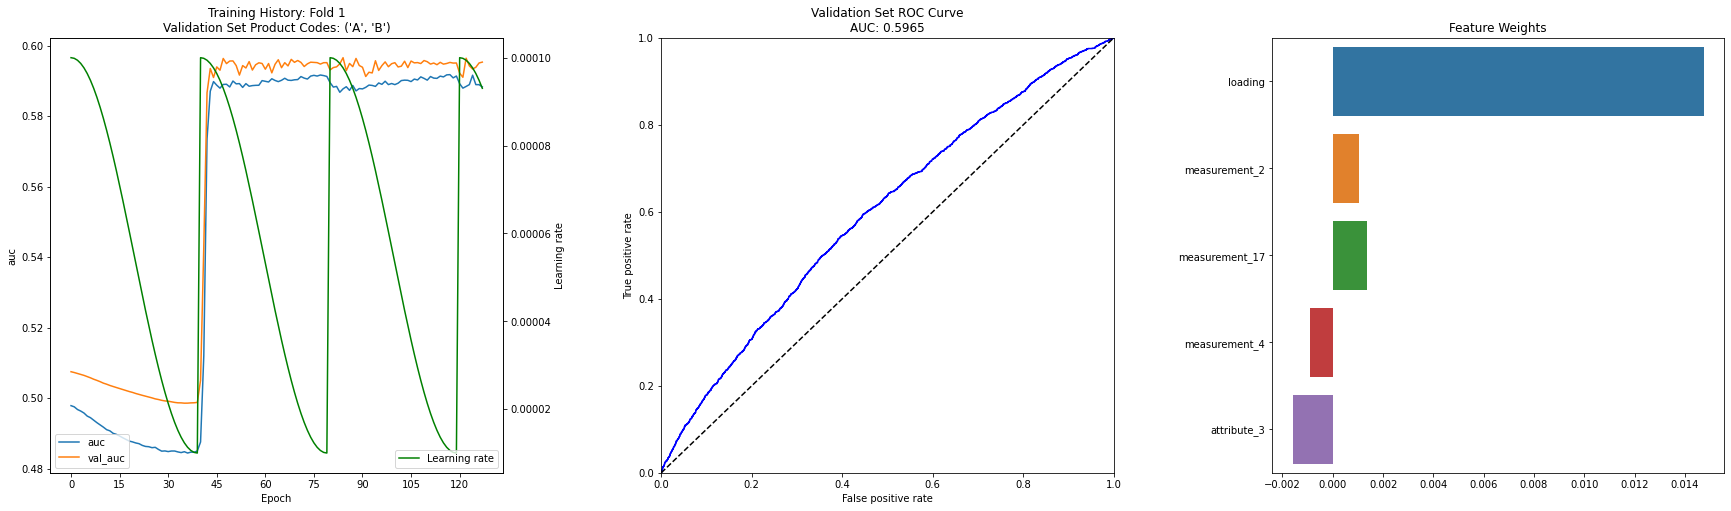

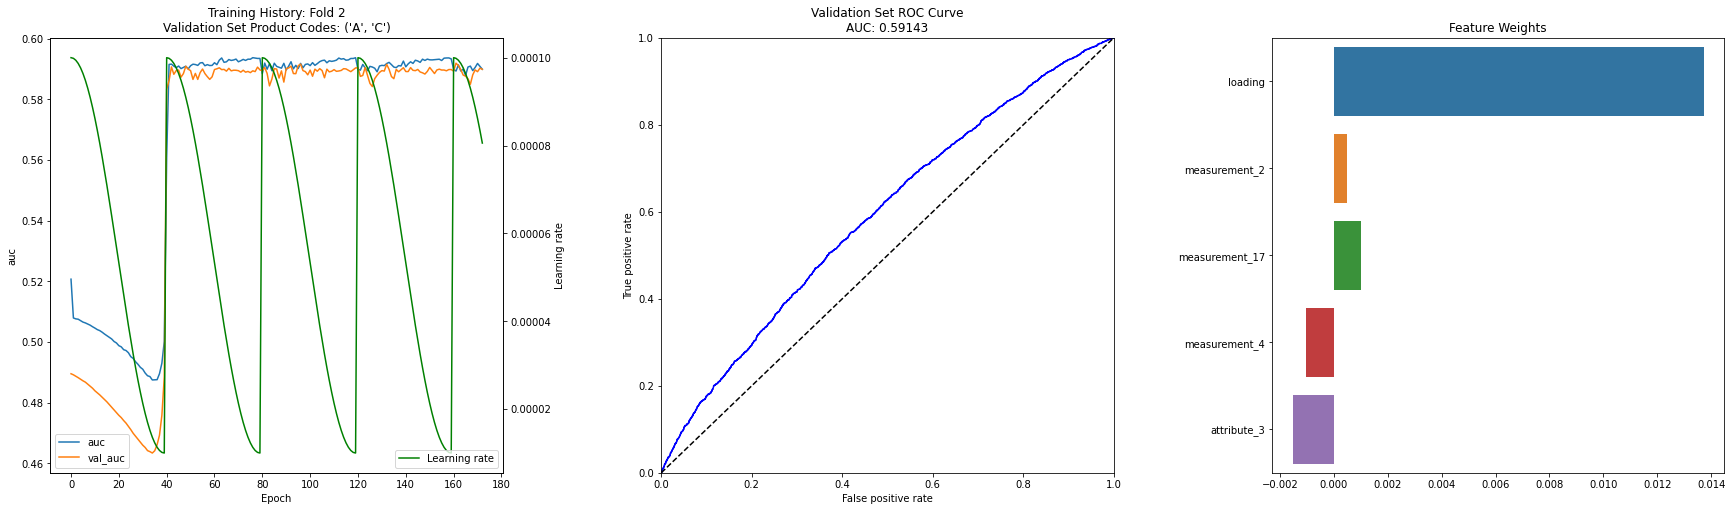

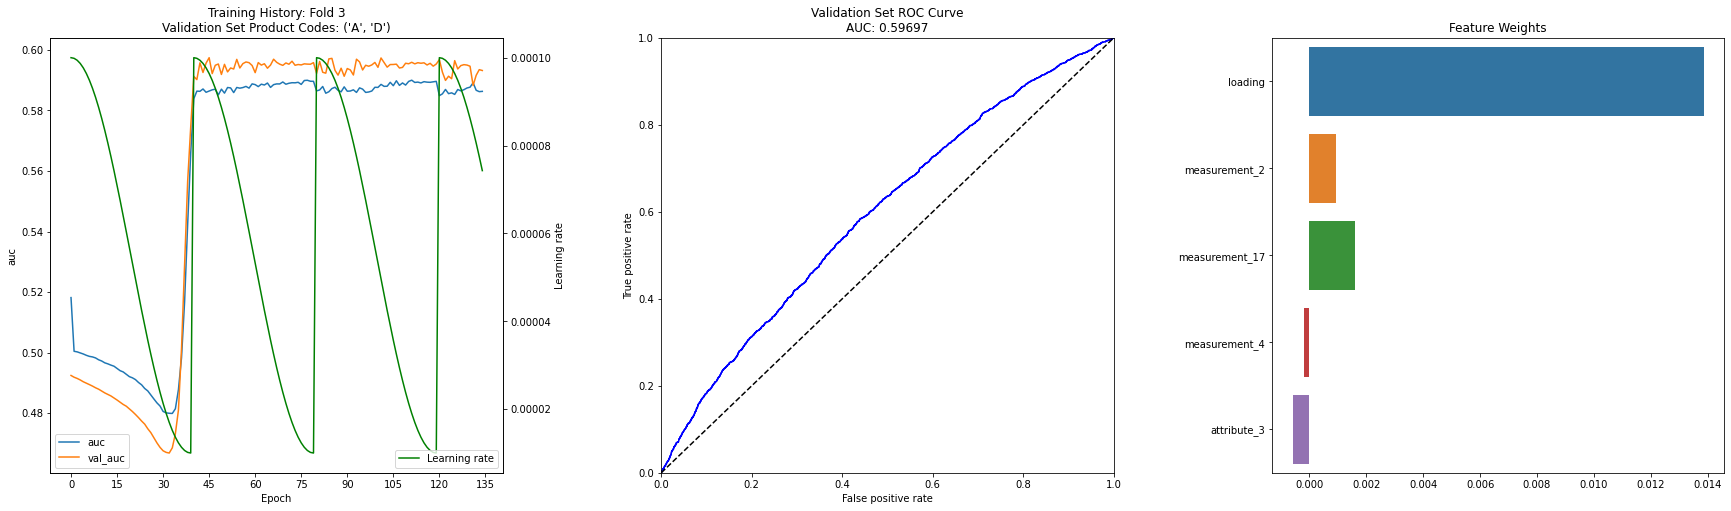

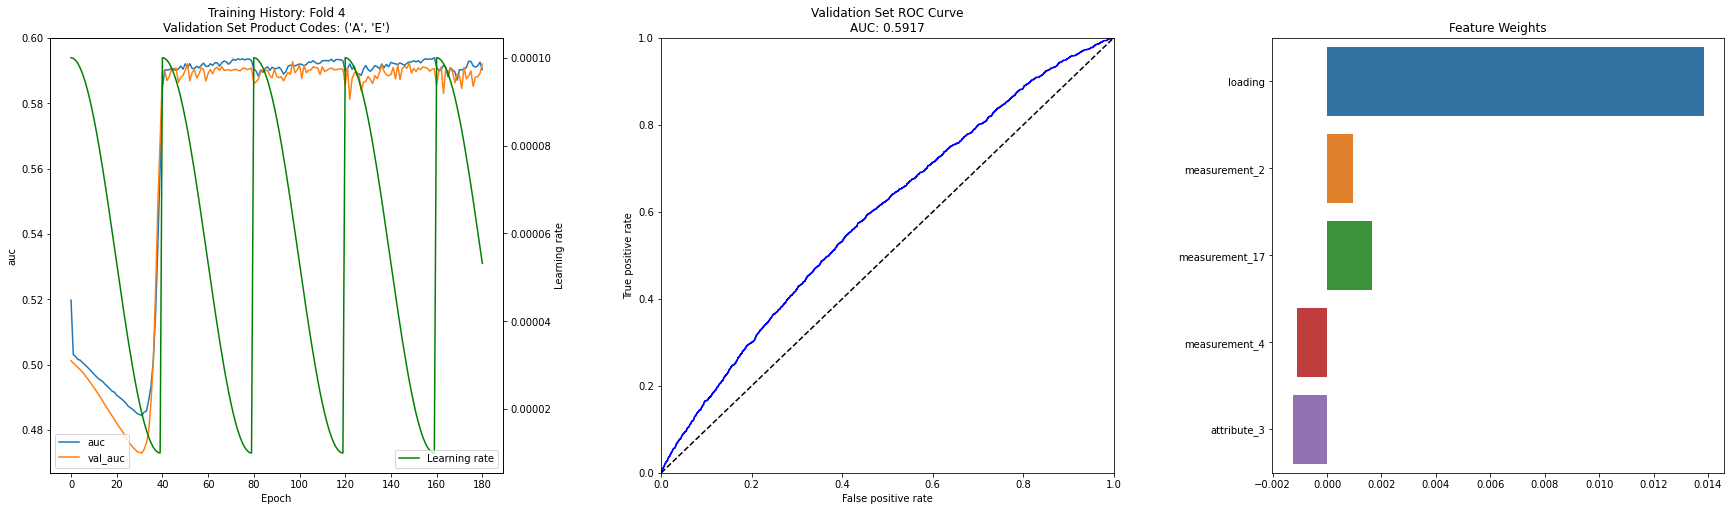

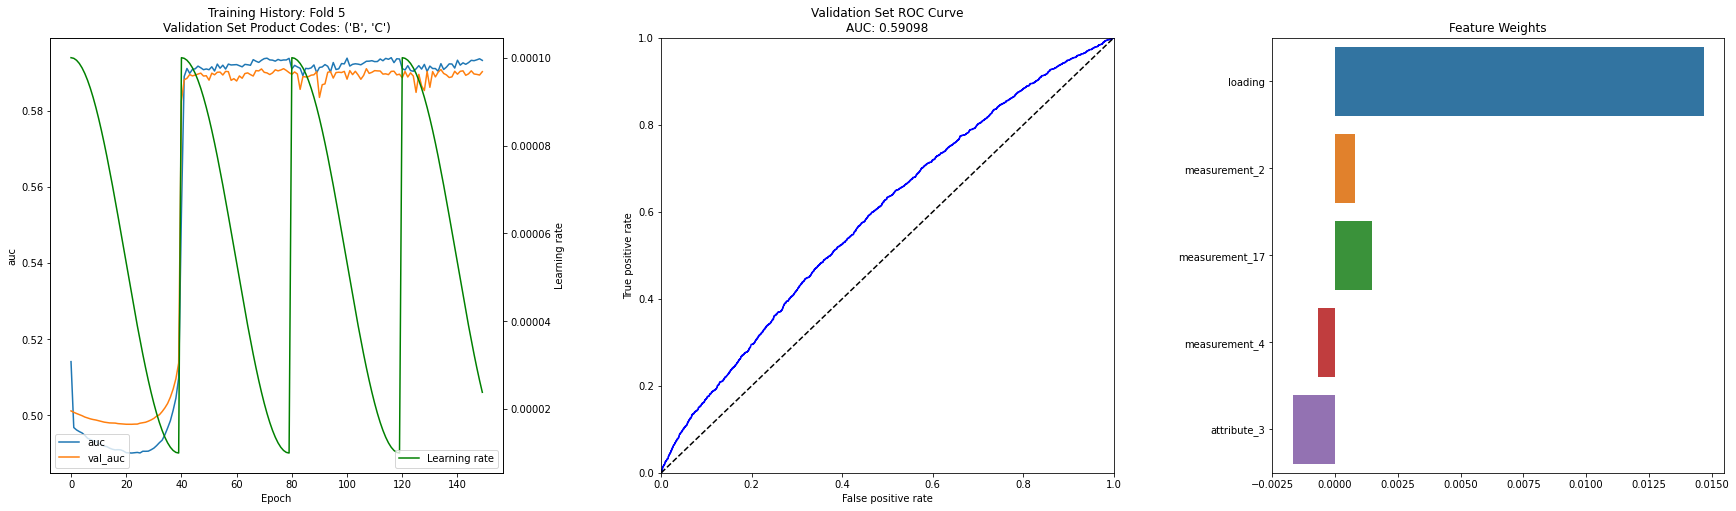

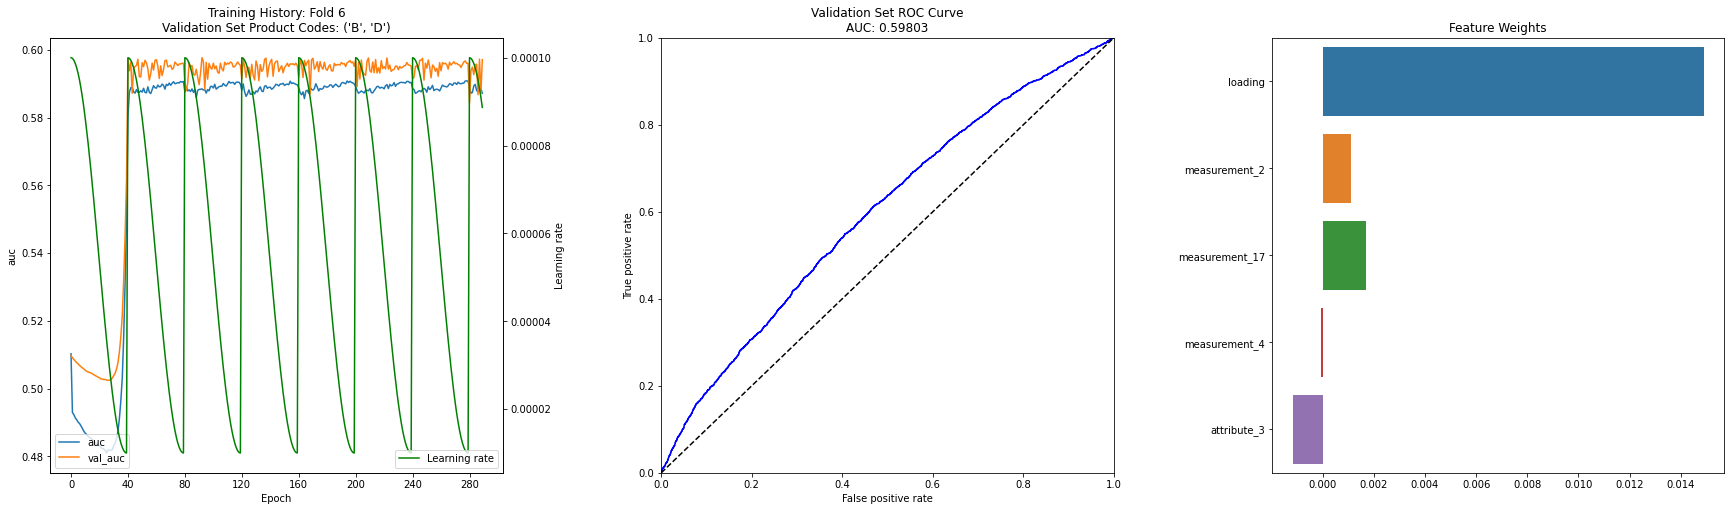

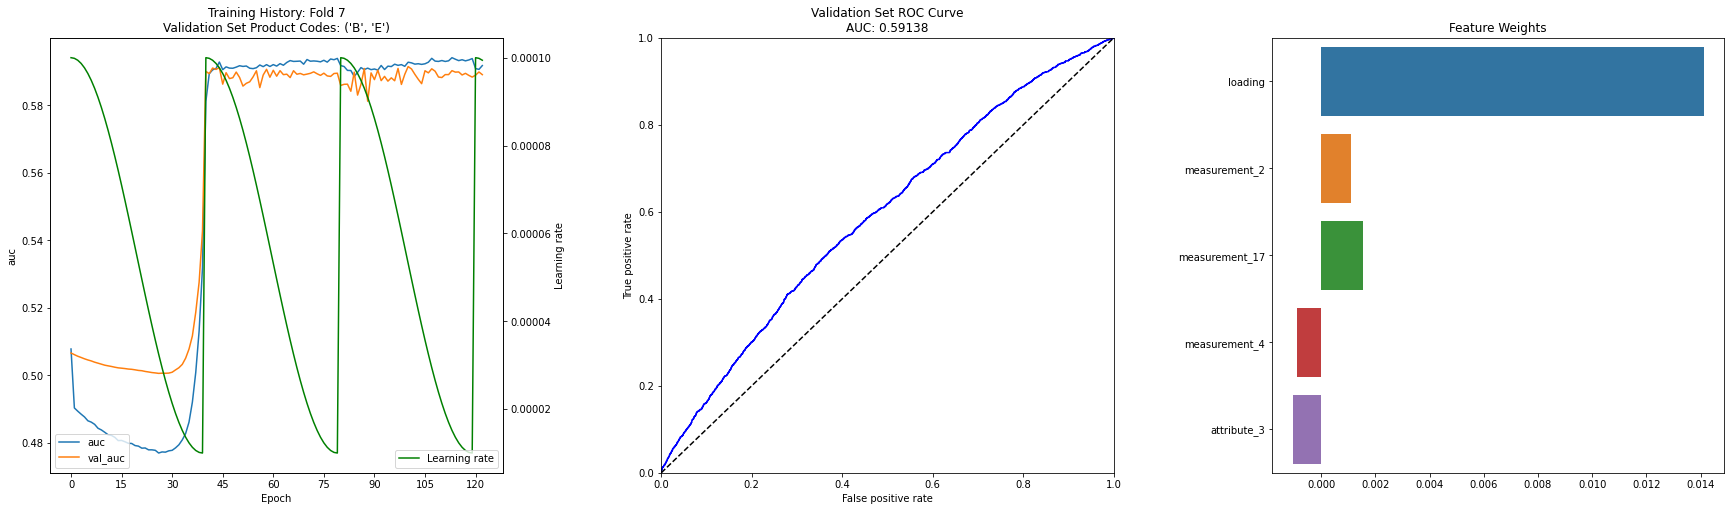

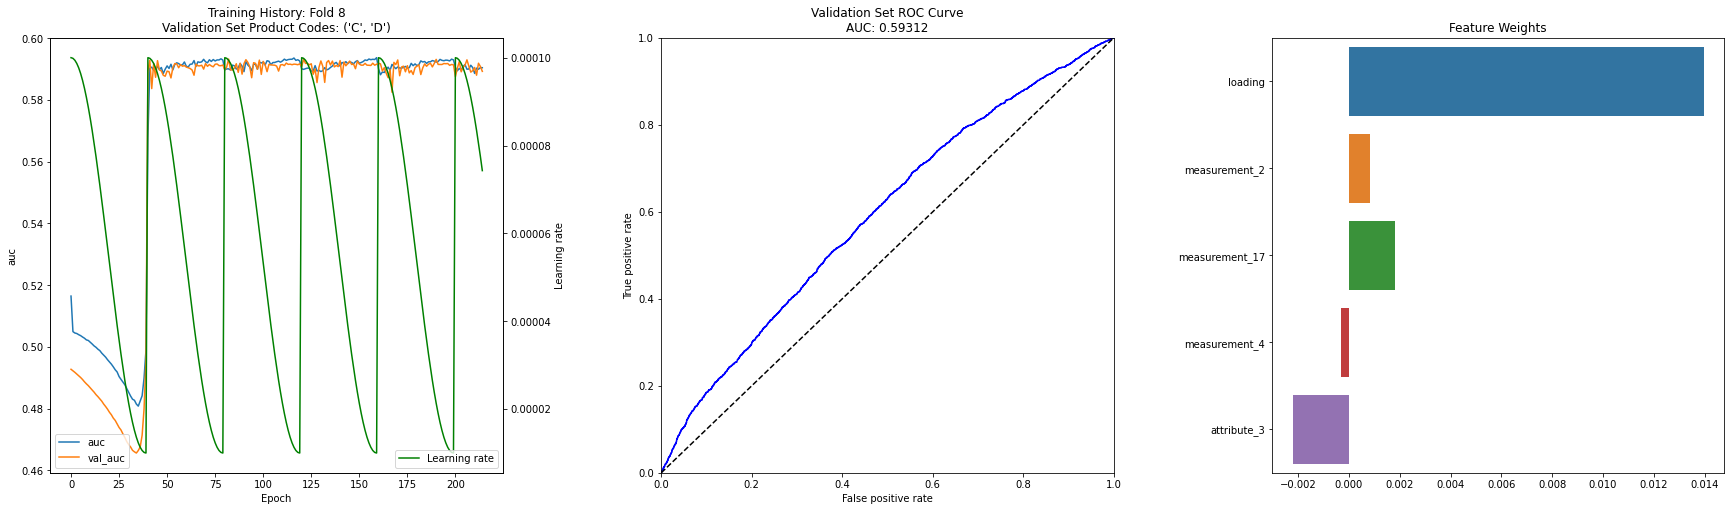

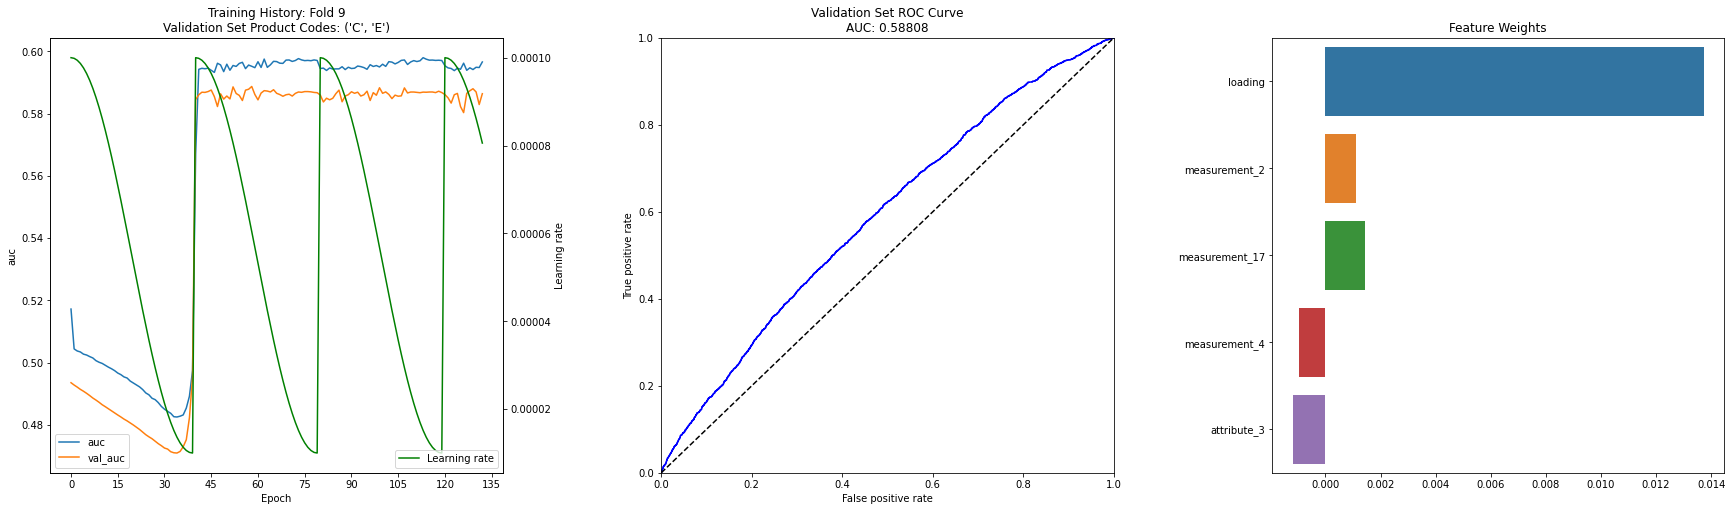

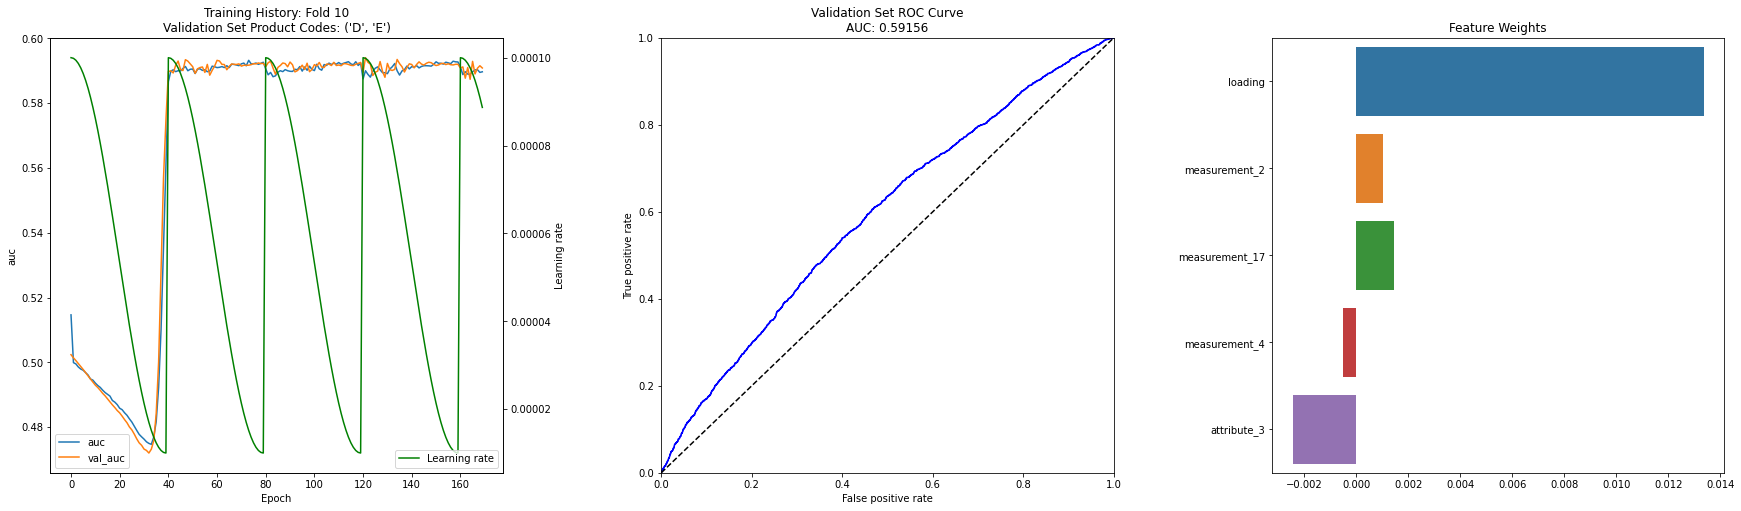



Mean validation set AUC: 0.59297
Mean epochs: 89
Median epochs: 79


In [23]:
best_epochs = list()
oof_auc = list()
best_auc = list()

for fold, val in enumerate(validation_indices):
    
    set_global_determinism(seed=SEED)
    
    X_train = train.iloc[training_indices[fold], :].copy()
    y_train  = target[training_indices[fold]].copy()
    X_valid = train.iloc[val, :].copy()
    y_valid = target[val].copy()
    
    X_train, X_valid = preprocess_data(X_train, X_valid)

    model = lr_model()
    model.compile(
            optimizer=OPTIMIZER,
            metrics= METRIC,
            loss=LOSS)

    class_weight = get_class_weight(y_train)
    
    history = model.fit(
            X_train,
            y_train,  
            validation_data=(
                            X_valid,
                            y_valid),
            epochs=EPOCHS,
            verbose=VERBOSE,
            batch_size=BATCH_SIZE,
            shuffle = True,
            callbacks=callbacks,
            class_weight=class_weight
           )
        
        
    history_list = []
    history_list.append(history.history)
    
    y_pred = model.predict(X_valid).squeeze()
    X_valid_auc = np.round(roc_auc_score(y_valid,y_pred),5)
    
    plot_history(
            history_list[0],
            title = f"Training History: Fold {fold + 1}\nValidation Set Product Codes: {cv_groups[fold]}",
            plot_lr = True, n_epochs=EPOCHS, loss_or_metric='auc', val_loss_or_metric='val_auc',
            y_pred = np.round(y_pred), y_pred_proba=y_pred, y_valid=y_valid, X_valid_auc=X_valid_auc,
            weights=model.get_weights()[0].squeeze())
    
    best_epochs.append(np.argmin(np.array(history.history['val_loss'])))
    oof_auc.append(X_valid_auc)
    
    print('\n')

mean_epochs = int(np.round(np.mean(best_epochs)))
median_epochs = int(np.round(np.median(best_epochs)))

print(f"Mean validation set AUC: {np.round(np.mean(oof_auc),5)}")
print(f"Mean epochs: {mean_epochs}")
print(f"Median epochs: {median_epochs}")

# Train model on all training data

The mean and median epochs from cross-validation are 89 and 79, respectively. From the training history, it appears nothing is learned past 40 epochs. Therefore, 80 is the most sensible value to use, because the learning rate cycles every 40 epochs and so 80 is an epoch at the end of the second learning rate cycle. Choosing a multiple of 40 will likely allow the weights to settle at a low point of the loss surface minima.

In [24]:
set_global_determinism(seed=SEED)

callbacks = [lr]
X, X_test = preprocess_data(train, test)

model = lr_model()
model.compile(
        optimizer=OPTIMIZER,
        metrics= METRIC,
        loss=LOSS)

class_weight = get_class_weight(target)

history = model.fit(
        X,
        target,
        epochs=80,
        verbose=VERBOSE,
        batch_size=BATCH_SIZE,
        shuffle = True,
        callbacks=callbacks,
        class_weight=class_weight
       )

pred_prob = model.predict(X_test).squeeze()
y_pred = rankdata(pred_prob)

# Predictions submission

In [25]:
df_pred = pd.DataFrame(y_pred, columns = ['failure'])  
sub = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')
sub['failure'] = df_pred['failure']
sub.to_csv('submission.csv',index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
